In [0]:
%matplotlib inline

In [0]:
from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

In [0]:
SEED = 3264602 # from random.org

np.random.seed(SEED)

In [0]:
N = 10000

μ_actual = np.array([1, -2])
Σ_actual = np.array([[0.5, -0.3],
                     [-0.3, 1.]])

x = np.random.multivariate_normal(μ_actual, Σ_actual, size=N)

In [0]:
var, U = np.linalg.eig(Σ_actual)
angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))

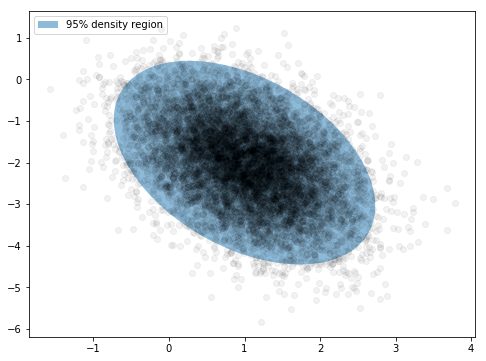

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red, *_ = sns.color_palette()

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]),
            2 * np.sqrt(5.991 * var[1]),
            angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10);
ax.add_artist(e);

ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.05, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect], ['95% density region'], loc=2);

In [0]:
with pm.Model() as model:
    packed_L = pm.LKJCholeskyCov('packed_L', n=2,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))

In [27]:
packed_L.tag.test_value.shape

(3,)

In [28]:
with model:
    L = pm.expand_packed_triangular(2, packed_L)
    Σ = pm.Deterministic('Σ', L.dot(L.T))

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [29]:
L.tag.test_value.shape

(2, 2)

In [0]:
with model:
    μ = pm.Normal('μ', 0., 10., shape=2,
                  testval=x.mean(axis=0))
    obs = pm.MvNormal('obs', μ, chol=L, observed=x)

In [31]:
with model:
    trace = pm.sample(random_seed=SEED, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


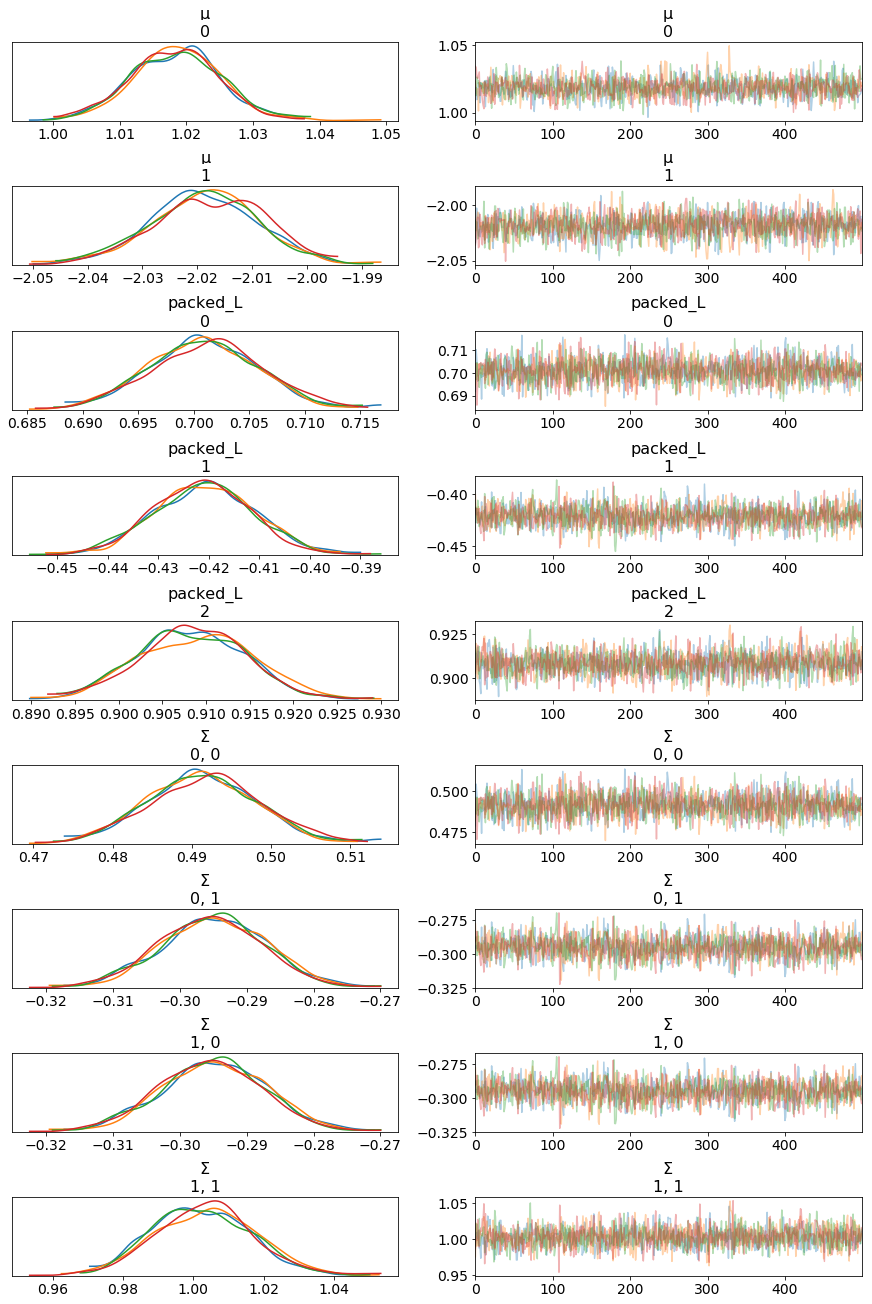

In [32]:
pm.traceplot(trace);

In [33]:
max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())

1.0012044309548285

In [34]:
μ_post = trace['μ'].mean(axis=0)
1 - μ_post / μ_actual

array([-0.01839854, -0.00931653])

In [35]:
Σ_post = trace['Σ'].mean(axis=0)
1 - Σ_post / Σ_actual

array([[ 0.01733446,  0.01612273],
       [ 0.01612273, -0.00270135]])

In [0]:
var_post, U_post = np.linalg.eig(Σ_post)
angle_post = 180. / np.pi * np.arccos(np.abs(U_post[0, 0]))

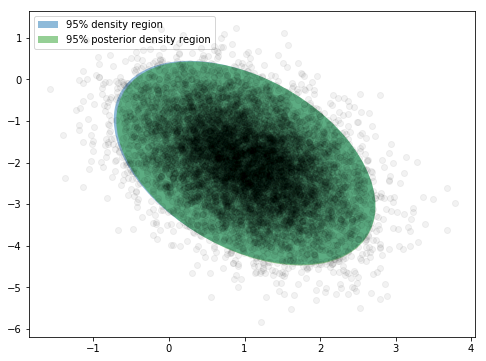

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]),
            2 * np.sqrt(5.991 * var[1]),
            angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10);
ax.add_artist(e);

e_post = Ellipse(μ_post, 2 * np.sqrt(5.991 * var_post[0]),
                 2 * np.sqrt(5.991 * var_post[1]),
                 angle=angle_post)
e_post.set_alpha(0.5)
e_post.set_facecolor(red)
e_post.set_zorder(10);
ax.add_artist(e_post);

ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.05, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
rect_post = plt.Rectangle((0, 0), 1, 1, fc=red, alpha=0.5)
ax.legend([rect, rect_post],
          ['95% density region',
           '95% posterior density region'],
          loc=2);

from google.colab import files
plt.savefig('Credible.svg')
files.download('Credible.svg') 